# Population Structure and PCA In Class Exercise
Module: Population Differentiation & Demography \
Topic: Population structure.

In [2]:
# Import modules.
import demes
import demesdraw
import numpy as np
import stdpopsim
import msprime
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# Print versions.
print('demes', demes.__version__)
print('demesdraw', demesdraw.__version__)
print('msprime', msprime.__version__)
print('numpy', np.__version__)
print('stdpopsim', stdpopsim.__version__)

/opt/conda/envs/biol1435/lib/python3.9/site-packages/stdpopsim/catalog/HomSap/demographic_models.py:158: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.head(1) - 1), rate=0
/opt/conda/envs/biol1435/lib/python3.9/site-packages/stdpopsim/catalog/HomSap/demographic_models.py:161: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  time=int(extended_GF.time.tail(1) + 1), rate=0


demes 0.2.3
demesdraw 0.4.0
msprime 1.3.3
numpy 1.26.4
stdpopsim 0.2.0


## Simulations
Here I am using the `stdpopsim` catalog of standardized demographic models to generate these simulations. You can read more about `stdpopsim` [here](https://popsim-consortium.github.io/stdpopsim-docs/stable/index.html), to learn more about this AWESOME package! First, I will extract and visualize the demographic model that describes the evolution of North American ducks from [Lavretsky et al., 2019](https://doi.org/10.1111/mec.15343).

In [3]:
# Intialize the species information.
species = stdpopsim.get_species('AnaPla')
# Intialize the demographic model.
duck_demo = species.get_demographic_model('MallardBlackDuck_2L19')
# Convert the demographic model to a demes graph.
duck_graph = msprime.Demography.to_demes(duck_demo.model)

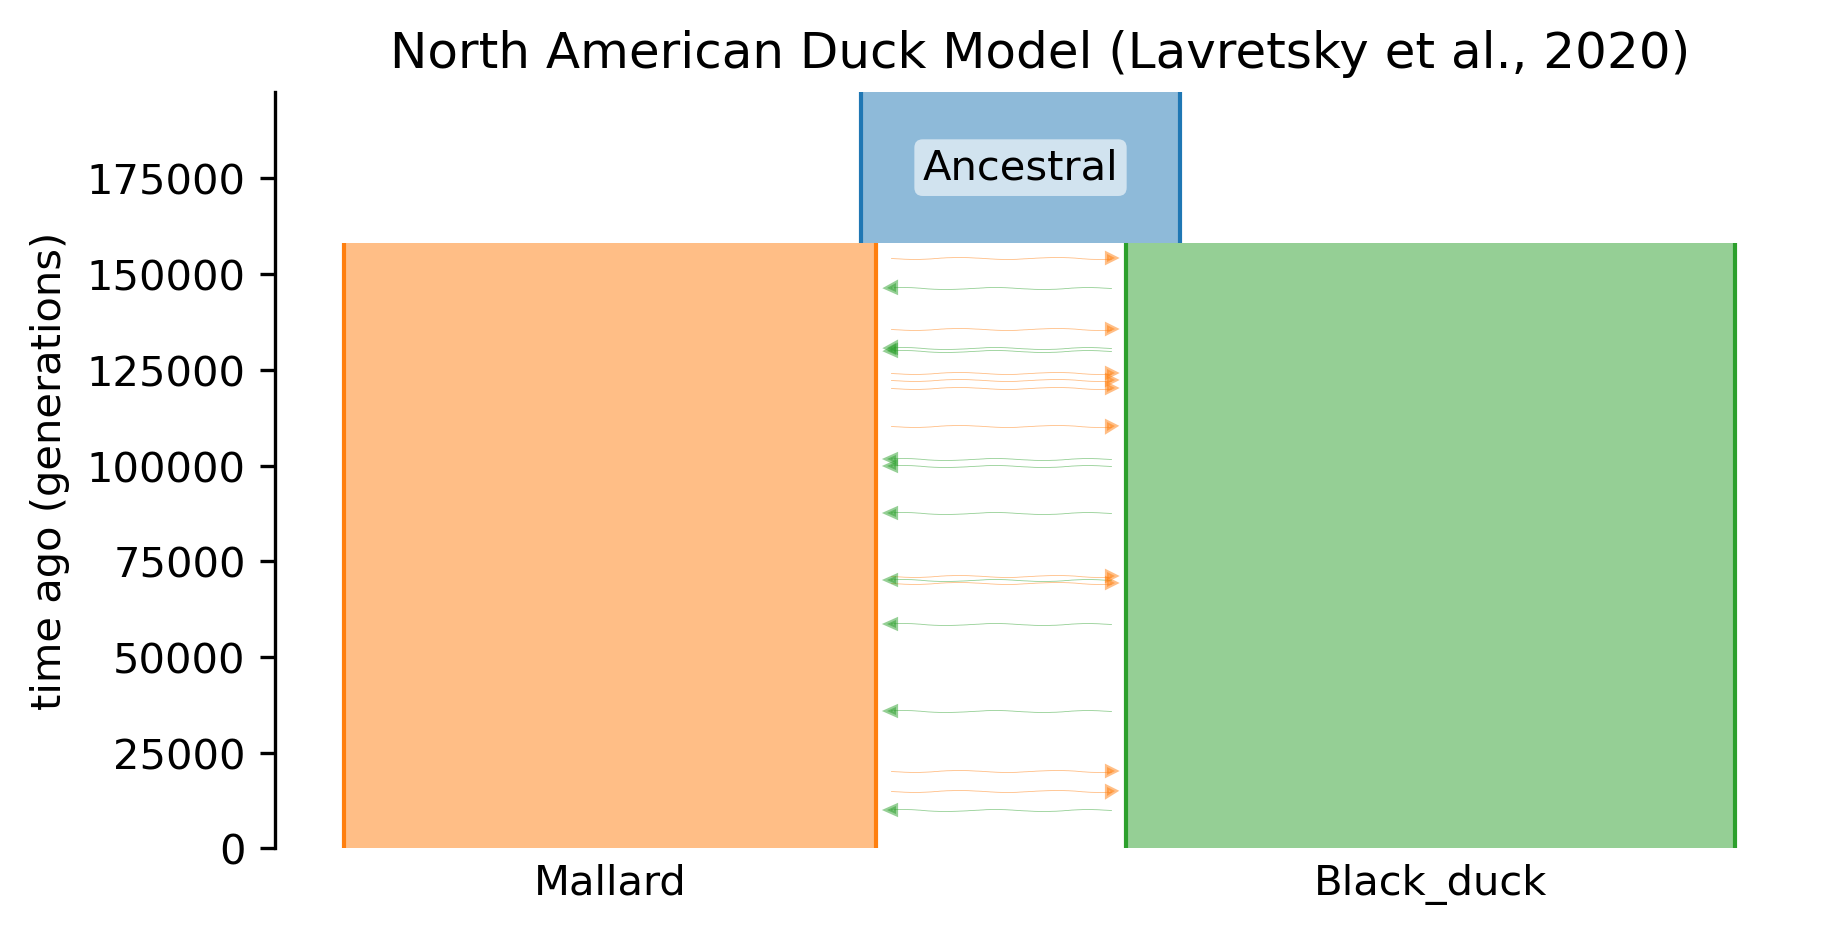

In [4]:
# Intialize the figure.
fig = plt.figure(
    figsize=(6, 3),
    constrained_layout=True,
    dpi=300.0,
)
# Intialize the axes.
ax = fig.add_subplot(111)
# Plot the demes graph.
demesdraw.tubes(
    duck_graph,
    ax=ax,
    title='North American Duck Model (Lavretsky et al., 2020)',
    seed=42,
)
# Show the plot.
plt.show()

Everything looks like the [catalog](https://popsim-consortium.github.io/stdpopsim-docs/stable/catalog.html#sec_catalog_anapla_models_mallardblackduck_2l19) entry for this model! Next, I will simulate a 10 Mb segment and sample 20 diploid ducks per population using the recombination and mutation rates described in the [catalog](https://popsim-consortium.github.io/stdpopsim-docs/stable/catalog.html#sec_catalog_AnaPla).

In [5]:
# Simulate.
ts = msprime.sim_ancestry(
    samples=[
        msprime.SampleSet(20, ploidy=2, population='Mallard'),
        msprime.SampleSet(20, ploidy=2, population='Black_duck'),
    ],
    demography=duck_demo.model,
    sequence_length=1e5,
    recombination_rate=1.43e-08,
    random_seed=42,
)
# Overlay mutations at a rate of 4.83e-09 per base pair per generation.
mts = msprime.sim_mutations(
    tree_sequence=ts,
    rate=4.83e-09,
    random_seed=42,
    discrete_genome=False,
)

Lastly, I will extract the genotype matrix to perform calculations on.

In [6]:
# Extract the genotype matrix.
geno_mat = mts.genotype_matrix()

## PCA

First thing we will need to do for the PCA is convert our genotype matrix to an allele count $C$ matrix.

In [7]:
# STEP 1: Look at and organize your data
# Intialize an empty C matrix.
C_mat = np.empty((geno_mat.shape[1] // 2, geno_mat.shape[0]))
# Intialize a column counter.
c_idx = 0
# For every individual...
for ind in np.arange(0, geno_mat.shape[1], 2):
    # Extract the two homologous chromosomes.
    chrom_1 = geno_mat[:, ind]
    chrom_2 = geno_mat[:, ind+1]
    # Convert the diploid genotypes to derived allele counts.
    C_mat[c_idx, :] = chrom_1 + chrom_2
    # Move the counter forward.
    c_idx += 1

Next, we need to subtract each column in our $C$ matrix by the column mean $\mu(j)$ and then divide by the standard deviation to create our zero centered $M$ matrix. Note that we will use the standard deviation of the binomial distribution (i. e. $\sqrt{p(j)(1-p(j))}$ ) where $p(j) = \frac{\mu(j)}{2}$ is the allele frequency of the derived/alternative allele. We use $\sqrt{p(j)(1-p(j))}$ because is is proportional to the change in allele frequency due to genetic drift per generation.

In [8]:
# Calculate the column mean vector.
mu_vec = np.mean(C_mat, axis=0)
# Calculate the column allele frequency vector.
p_vec = mu_vec / 2
# Calculate the standard deviation vector.
std_vec = np.sqrt(((C_mat.shape[0] * 2) * p_vec * (1 - p_vec)))
# Convert the C matrix to a zero centered M matrix.
M_mat = (C_mat - mu_vec) / std_vec

Next, we need to compute the covariance matrix $X$, which can be done by computing the inner product between the zero centered $M$ matrix and its tranpose matrix (ie $M^{T}$) and then dividing by the the sample size minus one (ie $n - 1$).

In [9]:
# STEP 2: Final, computing the covariance matrix
# Compute the covariance matrix.
X_mat = np.dot(M_mat, M_mat.T) / (M_mat.shape[0] - 1)

Now, we will let `numpy` take over to perform the eigendecomposition to compute the eigenvalues and eigenvectors from the covariance matrix.

In [10]:
# STEP 3: Compute the eigen -values and -vectors.
eig_vals, eig_vecs = np.linalg.eig(X_mat)
# Sort the -values and -vectors.

# STEP 4: Sort the eigen vales and pick the corresponding eigen vectors (Principal components)
eig_idx = np.argsort(eig_vals)[::-1]
eig_vals = eig_vals[eig_idx]
eig_vecs = eig_vecs[:, eig_idx]

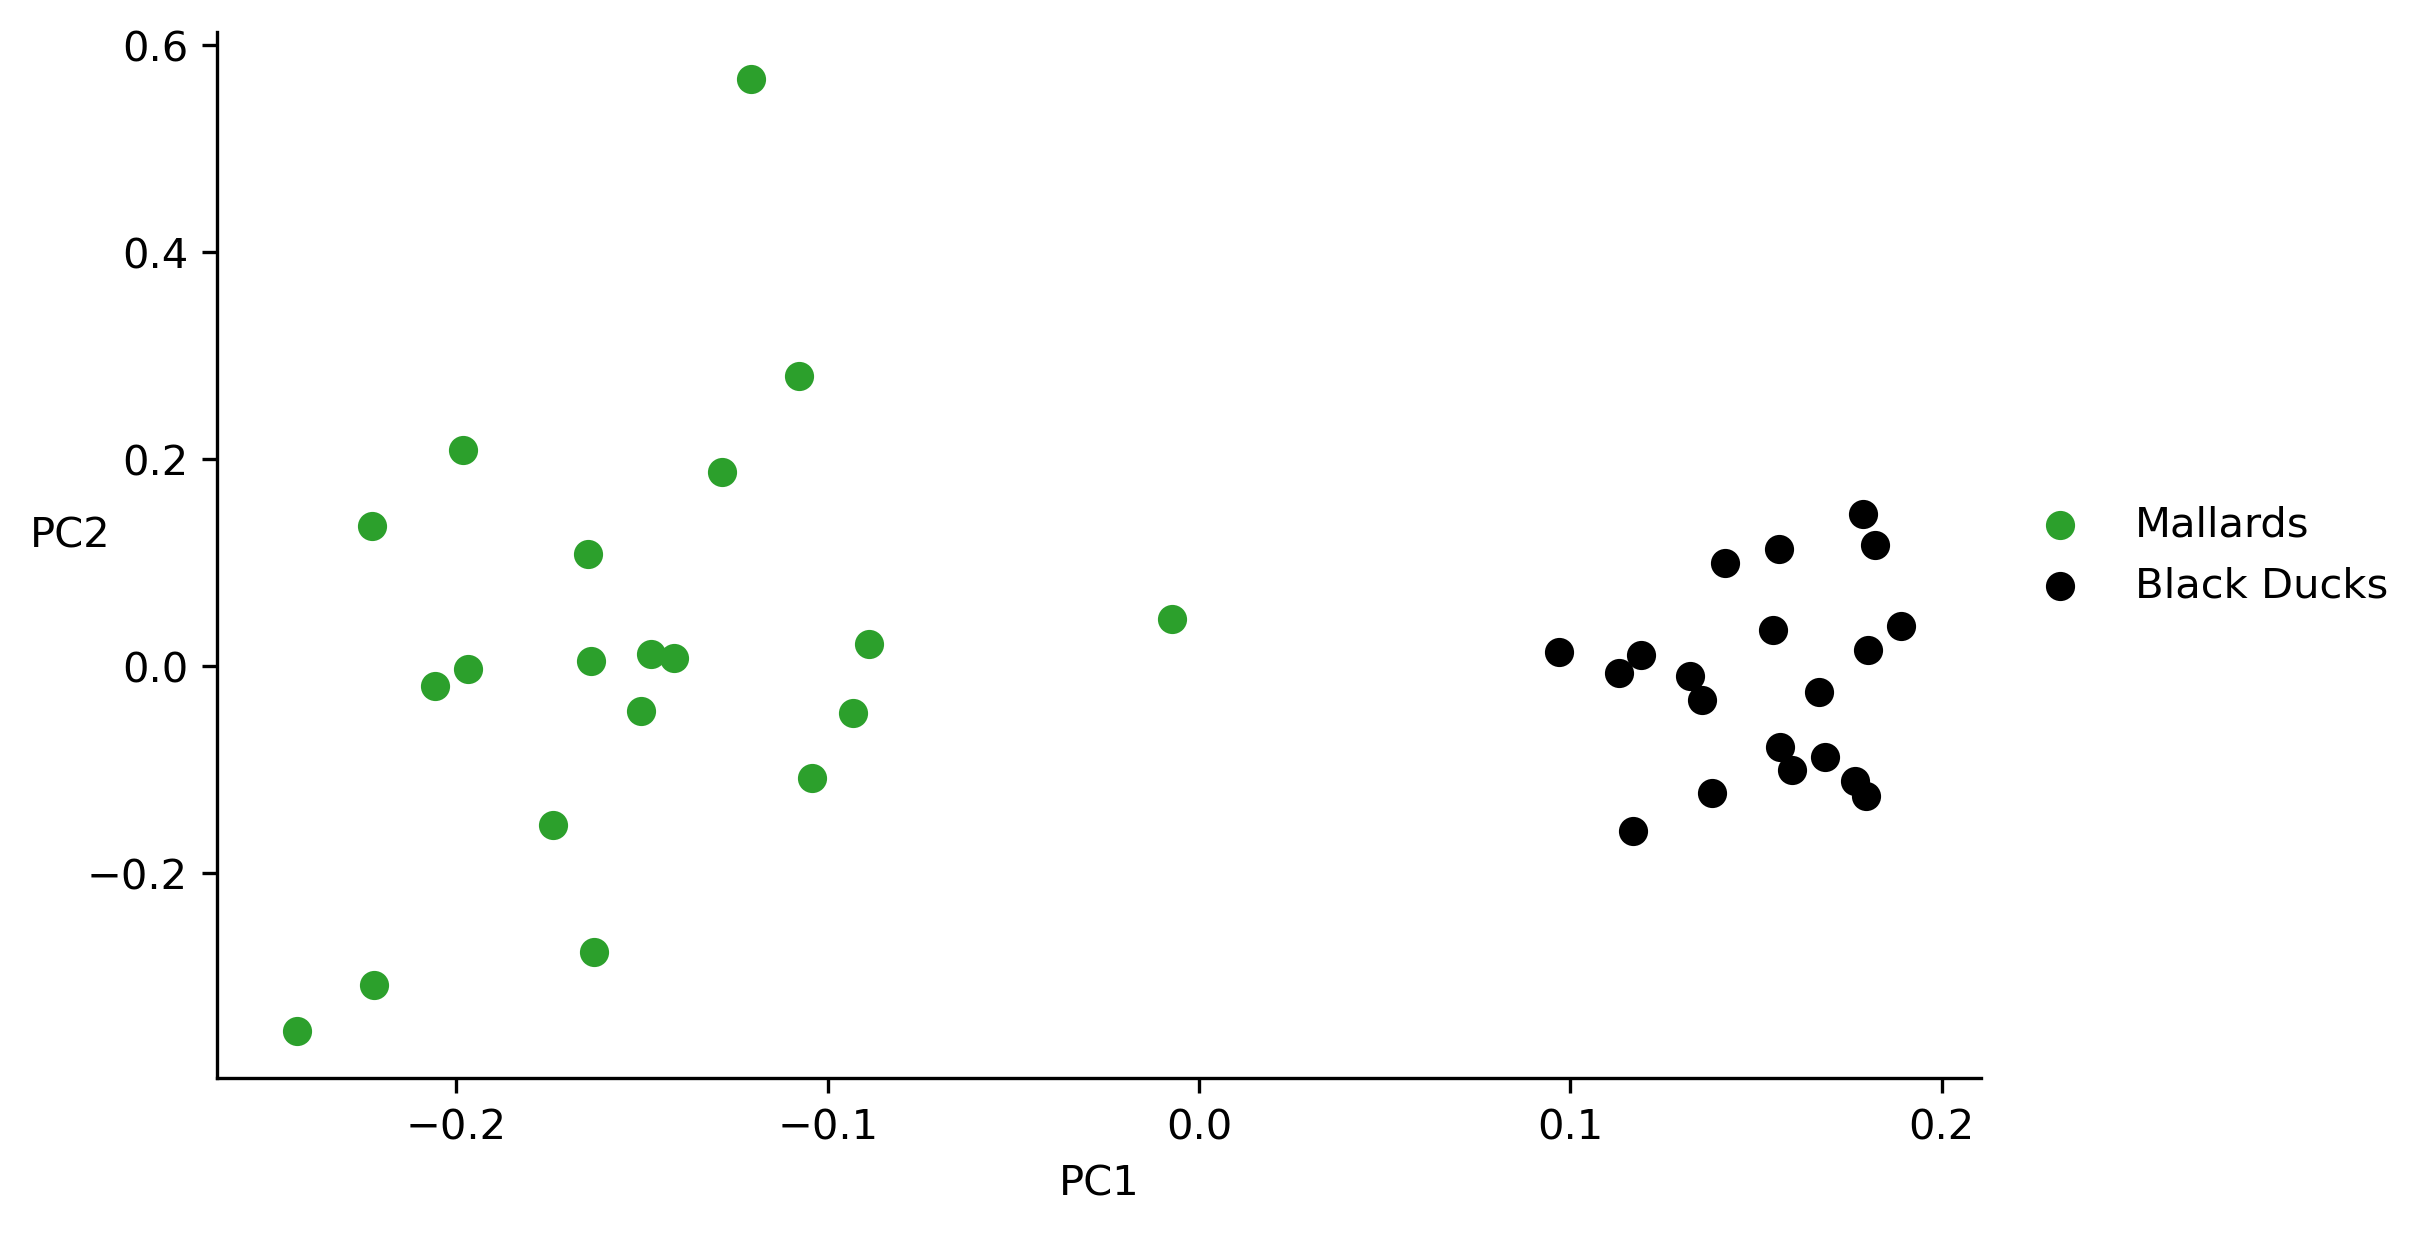

In [11]:
# STEP 5: Plot your first two principal components
# Intialize the figure.
fig = plt.figure(figsize=(8, 4), constrained_layout=True, dpi=300)
# Intialize the axes.
ax = fig.add_subplot(111)
# Plot the simulated results.
ax.scatter(
    eig_vecs[:20, 0], eig_vecs[:20, 1],
    color='tab:green', label='Mallards',
)
# Plot the analytical solutions.
ax.scatter(
    eig_vecs[20:, 0], eig_vecs[20:, 1],
    color='black', label='Black Ducks',
)
# Despine the axes.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Plot the legend.
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
# Label the axes.
plt.xlabel('PC1')
plt.ylabel('PC2', rotation=0)
# Show!
plt.show()

Think back to the North American Duck demographic model, from earlier in the notebook. Does this PCA make sense, why or why not? Now let's write a generalized function.

In [12]:
# Define a PCA function.
def pca(genotype_matrix):
    # Intialize an empty C matrix.
    C_mat = np.empty((int(genotype_matrix.shape[1] / 2), genotype_matrix.shape[0]))
    # Intialize a column counter.
    c_idx = 0
    # For every individual...
    for ind in np.arange(0, genotype_matrix.shape[1], 2):
        # Extract the two homologous chromosomes.
        chrom_1 = genotype_matrix[:, ind]
        chrom_2 = genotype_matrix[:, ind+1]
        # Convert the diploid genotypes to derived allele counts.
        C_mat[c_idx, :] = chrom_1 + chrom_2
        # Move the counter forward.
        c_idx += 1
    # Calculate the column mean vector.
    mu_vec = np.mean(C_mat, axis=0)
    # Calculate the column allele frequency vector.
    p_vec = mu_vec / 2
    # Determine the indicies of sites with more than one mutation is observed.
    good_idx = np.where(~((p_vec <= 1 / (C_mat.shape[0] * 2)) | (p_vec == 1)))[0]
    # Calculate the standard deviation vector.
    std_vec = np.sqrt(((C_mat.shape[0] * 2) * p_vec[good_idx] * (1 - p_vec[good_idx])))
    # Convert the C matrix to a zero centered M matrix.
    M_mat = (C_mat[:, good_idx] - mu_vec[good_idx]) / std_vec
    # Compute the covariance matrix.
    X_mat = np.dot(M_mat, M_mat.T) / (M_mat.shape[0] - 1)
    # Compute the eigen -values and -vectors.
    eig_vals, eig_vecs = np.linalg.eig(X_mat)
    # Sort the -values and -vectors.
    eig_idx = np.argsort(eig_vals)[::-1]
    eig_vals = eig_vals[eig_idx]
    eig_vecs = eig_vecs[:, eig_idx]
    return eig_vals, eig_vecs

## $F_{ST}$

The fixation index ($F_{ST}$) is a measure of how differentiated two populations are as a value between 0 and 1. A value of 0 indicates that the two populations are interbreeding freely and are not differentiable based on genetic variation. A value of 1 indicates that the two populations do not share any genetic diversity.

For these exercises we will be using Hudson's estimator of $F_{ST}$. This is because in order to estimate $F_{ST}$ this way, we only need the genotype matrices for the two populations. This is useful because other definitions for $F_{ST}$ make use of metrics that can't be easily obtained in practice.

Hudson's estimator of $F_{ST}$ is defined as follows: $F_{ST} = 1 - \frac{H_{w}}{H_{b}}$ where $H_{w} = p_1 \left(1 - p_1\right) + p_2 \left(1 - p_2\right)$ and $H_{b} = p_1 \left(1 - p_2 \right) + p_2 \left(1 - p_1 \right)$. $H_{w}$ is the average number of differences within populations, and $H_{b}$ is the average number of differences between populations. $p_1$ is the derived allele frequencies for population 1, and $p_2$ is the derived allele frequencies for population 2.

Note that this definition is for a per-site $F_{ST}$. We can then average the $F_{ST}$ values for all sites to find the average $F_{ST}$ between two populations.

In [ ]:
# Simulate.
ts = msprime.sim_ancestry(
    samples=[
        msprime.SampleSet(20, ploidy=2, population='Mallard'),
        msprime.SampleSet(20, ploidy=2, population='Black_duck'),
    ],
    demography=duck_demo.model,
    sequence_length=1e5,
    recombination_rate=1.43e-08,
    random_seed=42,
)

# Alternative model

split_model = msprime.Demography()
split_model.add_population(name='A',    initial_size=10_000)
split_model.add_population(name='B',    initial_size=10_000)
split_model.add_population(name='JOIN', initial_size=10_000)
split_model.add_population_split(time=10, derived=['A', 'B'], ancestral='JOIN')

ts = msprime.sim_ancestry(
    samples=[
        msprime.SampleSet(20, ploidy=2, population='A'),
        msprime.SampleSet(20, ploidy=2, population='B'),
    ],
    demography=split_model,
    sequence_length=1e5,
    recombination_rate=1.43e-08
)


# Overlay mutations at a rate of 4.83e-09 per base pair per generation.
mts = msprime.sim_mutations(
    tree_sequence=ts,
    rate=4.83e-09,
    random_seed=42,
    discrete_genome=False,
)
geno_mat = mts.genotype_matrix()

# Calculate derived allele frequencies.
md_freqs = geno_mat[:, :40].sum(axis=1) / geno_mat[:, :40].shape[1] # Mallard ducks.
bd_freqs = geno_mat[:, 40:].sum(axis=1) / geno_mat[:, 40:].shape[1] # Black ducks.
# Calculate the average gene diversity within the populations.
H_w = ((md_freqs * (1 - md_freqs)) + (bd_freqs * (1 - bd_freqs)))
# Calculate the average gene diversity between populations.
H_b = ((md_freqs * (1 - bd_freqs)) + (bd_freqs * (1 - md_freqs)))
# Calculatae the numerator and denominator of Fst.
fst_num = H_b - H_w
fst_den = H_b
# Calculate the per site Fst.
per_site_fst = fst_num / fst_den
# Calculate the average Fst for this locus.
avg_fst = np.sum(fst_num) / np.sum(fst_den)

(89,)


In [65]:
# Print a summary.
print('F_ST: {0}'.format(round(avg_fst, 3)))

F_ST: 0.013


How would you broadly intepret this result? Do they make sense? What would the $F_{ST}$ tell us if we only looked at ducks from the same population? Would you expect this estimate to be higher or lower if there was no on-going migration between duck populations? After you are convinced of what is going on let's write a generalized function based on derived allele frequencies. 

In [66]:
# Define a function to calculate the Fst for a given locus.
def avg_fst(pop_a_freqs, pop_b_freqs):
    # Calculate the average gene diversity within the populations.
    H_w = ((pop_a_freqs * (1 - pop_a_freqs)) + (pop_b_freqs * (1 - pop_b_freqs)))
    # Calculate the average gene diversity between populations.
    H_b = ((pop_a_freqs * (1 - pop_b_freqs)) + (pop_b_freqs * (1 - pop_a_freqs)))
    # Calculatae the numerator and denominator of Fst.
    fst_num = H_b - H_w
    fst_den = H_b
    # Calculate the per site Fst.
    per_site_fst = fst_num / fst_den
    # Calculate the average Fst for this locus.
    fst = np.sum(fst_num) / np.sum(fst_den)
    return fst

## Challenge

Now, let's do a challenge by looking at a multi-population human demographic model. This demographic model consists of an Admixed American population, which is a population that has arisen due to gene flow events—this is juxtaposed to introgression which involves the permant incoporation of genetic material between isolated populations. Using `stdpopsim` let's load and visualize the demographic model.

In [67]:
# Intialize the species information.
species = stdpopsim.get_species('HomSap')
# Intialize the demographic model.
human_demo = species.get_demographic_model('AmericanAdmixture_4B11')
# Convert the demographic model to a demes graph.
human_graph = msprime.Demography.to_demes(human_demo.model)

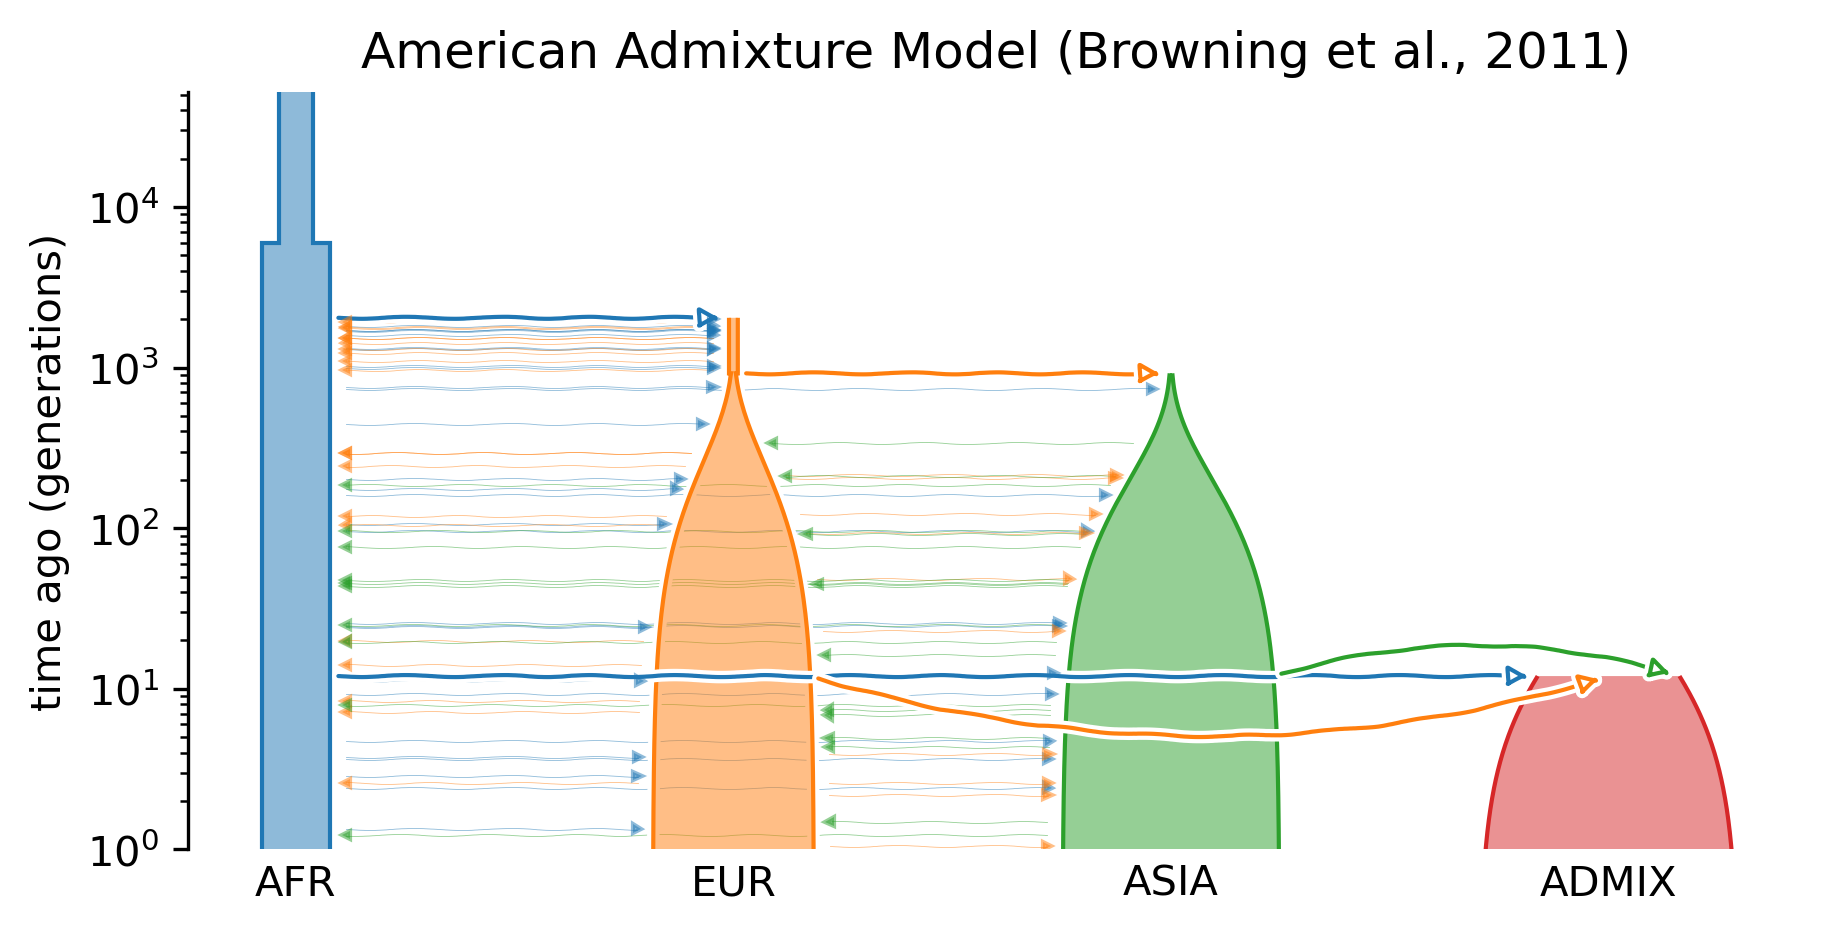

In [68]:
# Intialize the figure.
fig = plt.figure(
    figsize=(6, 3),
    constrained_layout=True,
    dpi=300.0,
)
# Intialize the axes.
ax = fig.add_subplot(111)
# Plot the demes graph.
demesdraw.tubes(
    human_graph,
    log_time=demesdraw.utils.log_time_heuristic(human_graph),
    ax=ax,
    title='American Admixture Model (Browning et al., 2011)',
    seed=42,
)
# Show the plot.
plt.show()

Now, let's simulate a 1 Mb sequence using the above demographic model and sample 100 diploid individuals per contemporary population.

In [69]:
# Simulate.
ts = msprime.sim_ancestry(
    samples=[
        msprime.SampleSet(100, ploidy=2, population='AFR'),
        msprime.SampleSet(100, ploidy=2, population='EUR'),
        msprime.SampleSet(100, ploidy=2, population='ASIA'),
        msprime.SampleSet(100, ploidy=2, population='ADMIX'),
    ],
    demography=human_demo.model,
    sequence_length=1e6,
    recombination_rate=1e-8,
    random_seed=42,
)
# Overlay mutations at a rate of 2.36e-8 per base pair per generation.
mts = msprime.sim_mutations(
    tree_sequence=ts,
    rate=2.36e-8,
    random_seed=42,
    discrete_genome=False,
)

Now, let's extract the genotype matrices and the derived allele frequency arrays from the mutated tree-sequence

In [70]:
# Extract the genotype matrix.
geno_mat = mts.genotype_matrix()
# Define the number of simulated chromosomes.
n_chroms = 200
# Extract derived allele frequency arrays.
afr_freqs = geno_mat[:, :200].sum(axis=1) / n_chroms
eur_freqs = geno_mat[:, 200:400].sum(axis=1) / n_chroms
asn_freqs = geno_mat[:, 400:600].sum(axis=1) / n_chroms
adx_freqs = geno_mat[:, 600:].sum(axis=1) / n_chroms

Now it is clear to see that the Admixed American population is derived of African, European, and Asian ancestry. What do you think the PCA should look like? Write a description below before running the next two cells, which will run the PCA analysis.

In [71]:
# Compute the eigen -values and -vectors.
e_vals, e_vecs = pca(geno_mat)

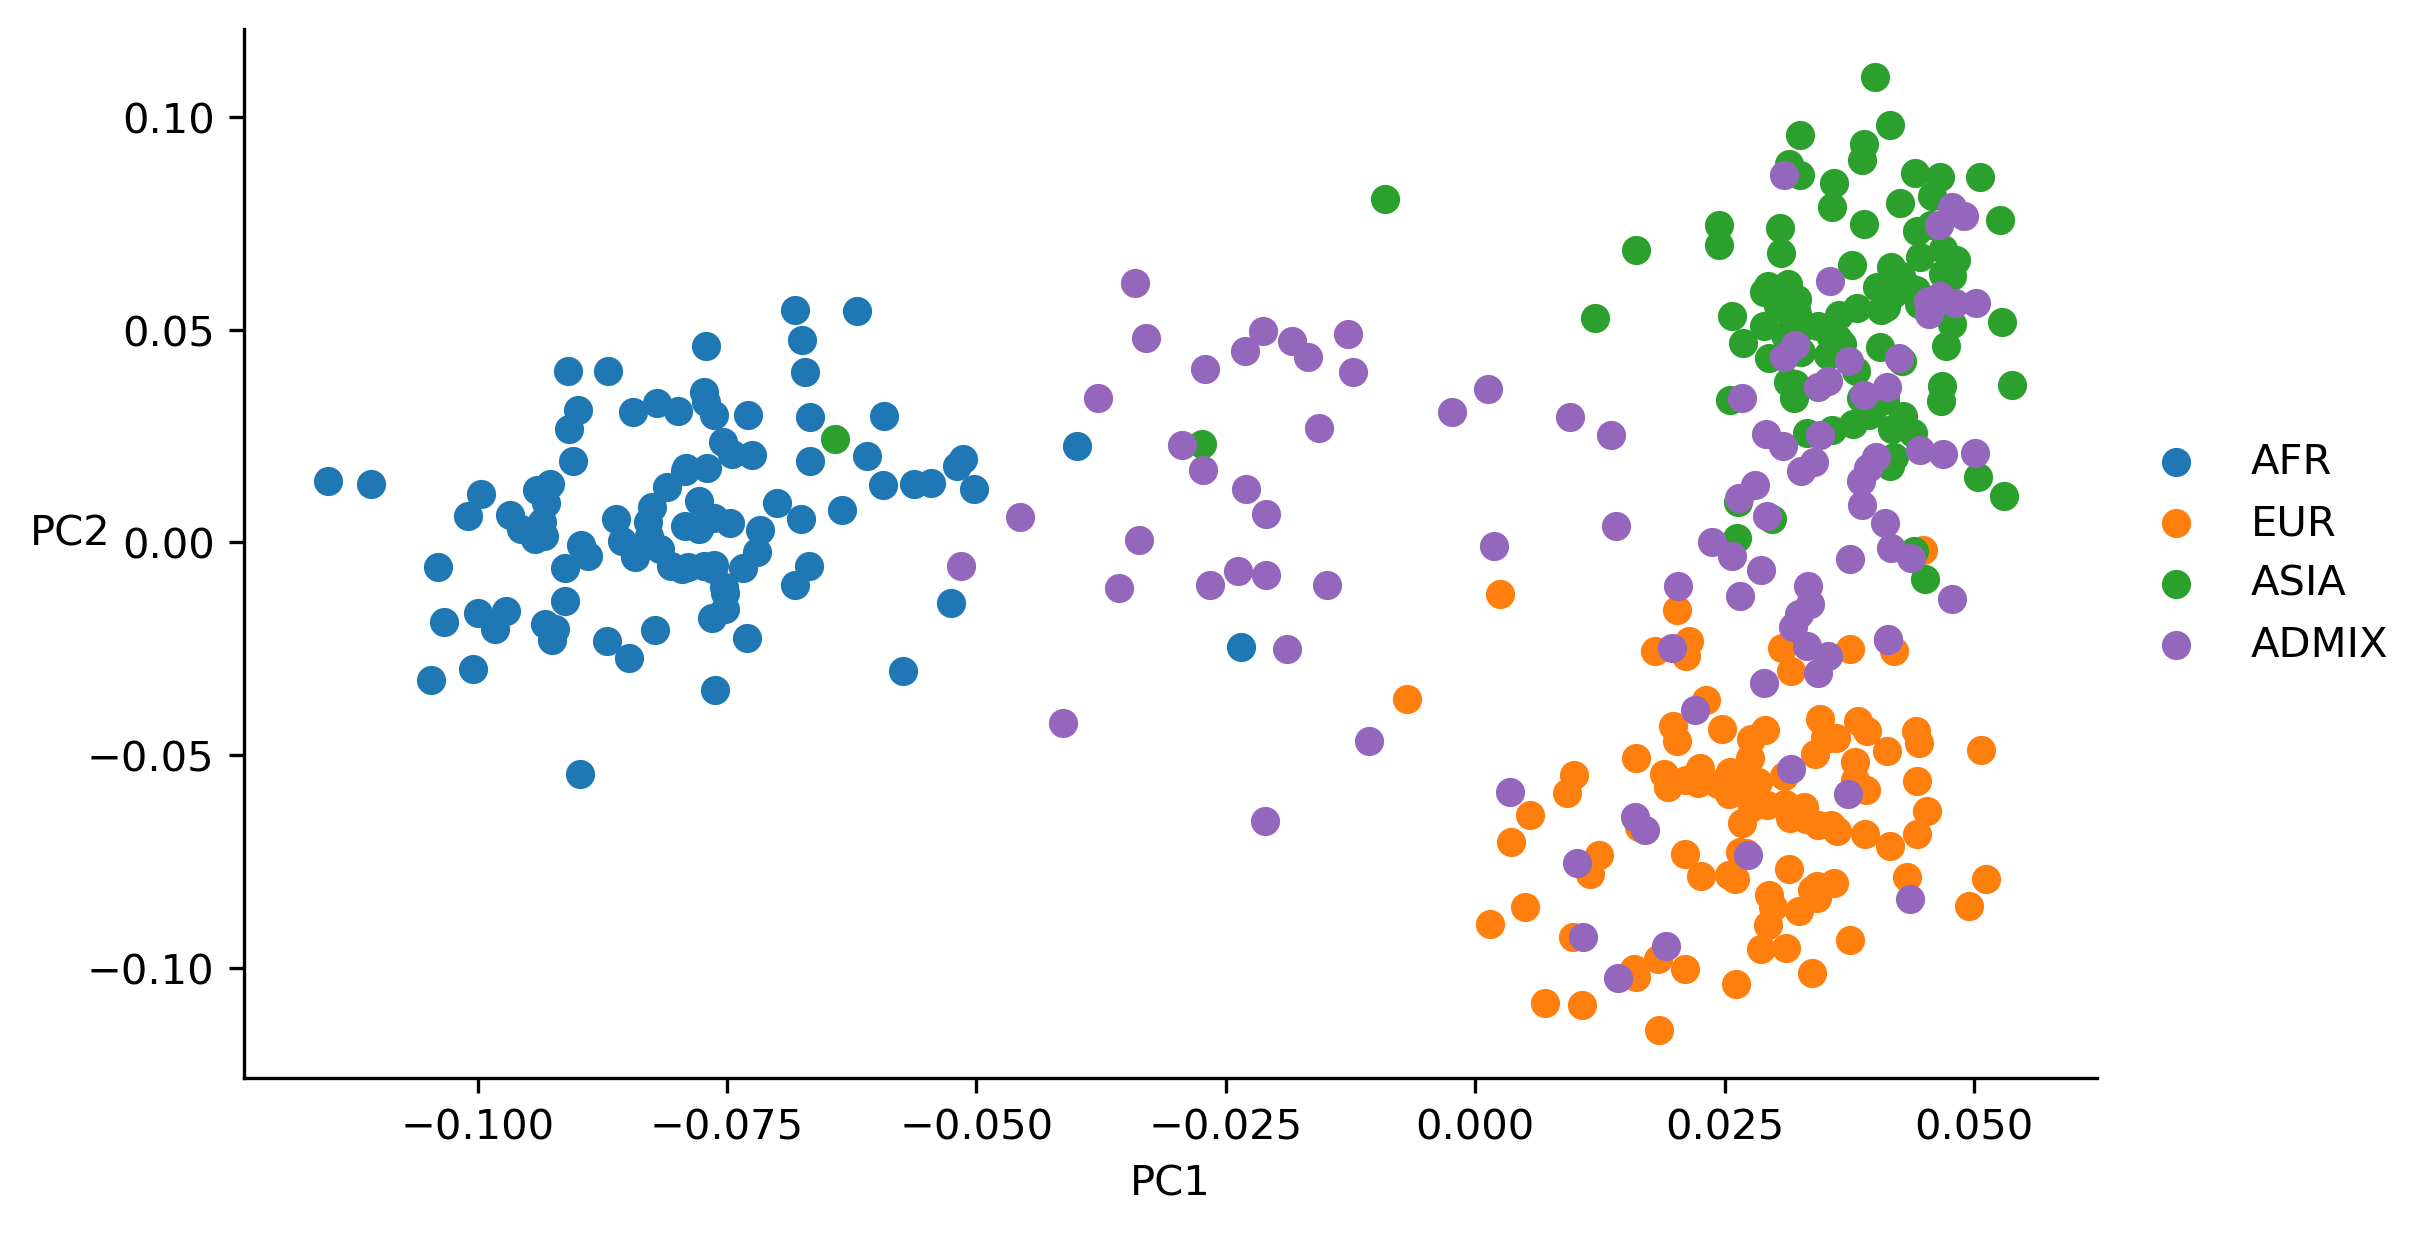

In [72]:
# Intialize the figure.
fig = plt.figure(figsize=(8, 4), constrained_layout=True, dpi=300)
# Intialize the axes.
ax = fig.add_subplot(111)
# Plot the simulated results.
# AFR.
ax.scatter(
    e_vecs[:100, 0], e_vecs[:100, 1],
    color='tab:blue', label='AFR',
)
# EUR.
ax.scatter(
    e_vecs[100:200, 0], e_vecs[100:200, 1],
    color='tab:orange', label='EUR',
)
# ASIA.
ax.scatter(
    e_vecs[200:300, 0], e_vecs[200:300, 1],
    color='tab:green', label='ASIA',
)
# ADMIX.
ax.scatter(
    e_vecs[300:, 0], e_vecs[300:, 1],
    color='tab:purple', label='ADMIX',
)
# Despine the axes.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Plot the legend.
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False)
# Label the axes.
plt.xlabel('PC1')
plt.ylabel('PC2', rotation=0)
# Show!
plt.show()

Does this PCA make sense? If not look back over the demographic model. If you are still stuck, ask the instructor for help! Next, lets compare the pairwise estimate of $F_{ST}$ between all populations.

In [78]:
# Intialize the matrix
fst_mat = np.empty((4, 4))
# Intialize a list of derived frequency arrays.
freq_list = [
    afr_freqs, eur_freqs,
    asn_freqs, adx_freqs,
]
for row in range(4):
    for col in range(4):
        # Extract the populations.
        pop_1 = freq_list[row]
        pop_2 = freq_list[col]
        # Fill the matricies.
        fst_mat[row, col] = avg_fst(pop_1, pop_2)

/tmp/ipykernel_111/995158236.py:11: RuntimeWarning: invalid value encountered in divide
  per_site_fst = fst_num / fst_den


Now, lets plot the two paiwrise divergence matricies. What are the overall trends among the populations? Do they make sense? Take a look at the diagnols, are they the same? Should they be the same? If you are not able to confidently answer all of those questions converse with a neighbor and then ask the instructor!

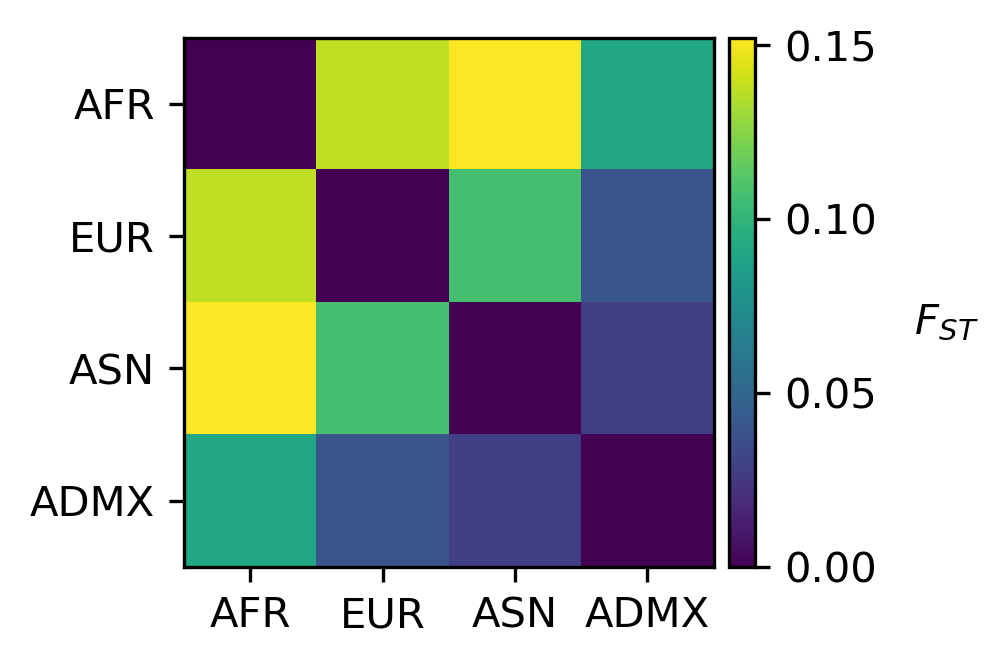

In [79]:
# Intialize the figure.
fig = plt.figure(figsize=(2.5, 2.5), constrained_layout=True, dpi=300)
# Intialize the axes.
ax = fig.add_subplot(111)
# Plot pairwise Fst estimates.
im = ax.imshow(fst_mat)
# Intialize the positions for the colobar.
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
# Plot the color bar.
cbar = fig.colorbar(im, cax=cax)
# Set and label the y-axis ticks.
ax.set_yticks(
    np.arange(4), 
    labels=['AFR', 'EUR', 'ASN', 'ADMX'],
)
# Set and label the x-axis ticks.
ax.set_xticks(
    np.arange(4),
    labels=['AFR', 'EUR', 'ASN', 'ADMX'],
)
# Annotate the colobar.
cbar.set_label(r'        $F_{ST}$', rotation=0)
# Show the plot!
plt.show()